In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Some Important import Libraray





In [ ]:
import pandas as pd             
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support as score
import gc
from collections import Counter
import warnings
import xgboost
import random
from scipy.stats import randint
import time
warnings.filterwarnings("ignore")

#Load CSV File

In [ ]:
data = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
data1 = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
data2 = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Friday-WorkingHours-Morning.pcap_ISCX.csv")
data3 = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Monday-WorkingHours.pcap_ISCX.csv")
data4 = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",encoding= 'unicode_escape')
data5 = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",encoding= 'unicode_escape')
data6 = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Tuesday-WorkingHours.pcap_ISCX.csv")
data7 = pd.read_csv("/content/drive/My Drive/TrafficLabelling_/Wednesday-workingHours.pcap_ISCX.csv")

#Concatenate all CSV file

In [ ]:
df = pd.concat([data,data1,data2,data3,data4,data5,data6,data7])
df.shape

(3119345, 85)

In [ ]:
df.keys()

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

#Data Cleaning

In [ ]:
df.isnull().sum()

Flow ID              288602
 Source IP           288602
 Source Port         288602
 Destination IP      288602
 Destination Port    288602
                      ...  
Idle Mean            288602
 Idle Std            288602
 Idle Max            288602
 Idle Min            288602
 Label               288602
Length: 85, dtype: int64

In [ ]:
df.dropna(how='all',inplace=True)
df.replace([np.inf, -np.inf,np.nan],0.0, inplace=True)
df.isnull().sum()
print('After removing All NULL values : ',df.isnull().sum().sum())
gc.collect()

After removing All NULL values :  0


4

In [ ]:
df = df.drop(['Flow ID'], axis=1)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.shape

(2830743, 84)

In [ ]:
df.head(2)

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,...,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,104.16.207.165,443.0,192.168.10.5,54865.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,...,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,33.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,104.16.28.216,80.0,192.168.10.5,55054.0,6.0,7/7/2017 3:30,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,...,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


# Preprocessing

In [ ]:
import socket,struct
sourceip = df[' Source IP'].to_numpy()
destinationip = df[' Destination IP'].to_numpy()
sip = []
dip = []
for i in range(len(sourceip)):
  sip.append(struct.unpack("!L",socket.inet_aton(sourceip[i])))
  dip.append(struct.unpack("!L",socket.inet_aton(destinationip[i])))

In [ ]:
sip = pd.DataFrame(sip)
dip = pd.DataFrame(dip)

In [ ]:
df[' Source IP'] = sip.astype('float64')
df[' Destination IP'] = dip.astype('float64')

In [ ]:
df['Flow Bytes/s'].replace(np.nan,0.1, inplace=True)
df['Flow Bytes/s']=df['Flow Bytes/s'].astype("float64")

In [ ]:
df[' Flow Packets/s'].replace(np.nan,0.1, inplace=True)
df[' Flow Packets/s']=df[' Flow Packets/s'].astype("float64")

In [ ]:
from datetime import datetime
df[' Timestamp'] = pd.to_datetime(df[' Timestamp'])
df[' Timestamp'].replace(['-',' ',':'], '',inplace=True)
df[' Timestamp']=df[' Timestamp'].values.astype('float64')
df[' Timestamp'].head(2)

0    1.499398e+18
1    1.499398e+18
Name:  Timestamp, dtype: float64

In [ ]:
df[' Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack \x96 Brute Force', 'Web Attack \x96 XSS',
       'Web Attack \x96 Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [ ]:
df.groupby(' Label').size()

 Label
BENIGN                        2273097
Bot                              1966
DDoS                           128027
DoS GoldenEye                   10293
DoS Hulk                       231073
DoS Slowhttptest                 5499
DoS slowloris                    5796
FTP-Patator                      7938
Heartbleed                         11
Infiltration                       36
PortScan                       158930
SSH-Patator                      5897
Web Attack  Brute Force         1507
Web Attack  Sql Injection         21
Web Attack  XSS                  652
dtype: int64

#Imbalance visulization Target Label With Multiclass

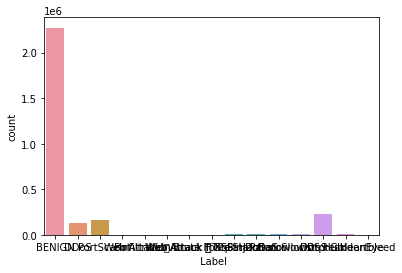

In [ ]:
sns.countplot(x=' Label',data=df)

#Label based indexing Using loc

In [ ]:
df1 = df.loc[df[' Label'] == 'BENIGN'].iloc[:1000]
df2 = df.loc[df[' Label'] == 'PortScan'].iloc[:1000]
df3 = df.loc[df[' Label'] == 'Bot'].iloc[:1000]
df4 = df.loc[df[' Label'] == 'Infiltration'].iloc[:1000]
df5 = df.loc[df[' Label'] == 'Web Attack \x96 Brute Force'].iloc[:1000]
df6 = df.loc[df[' Label'] == 'Web Attack \x96 XSS'].iloc[:1000]
df7 = df.loc[df[' Label'] == 'Web Attack \x96 Sql Injection'].iloc[:1000]
df8 = df.loc[df[' Label'] == 'FTP-Patator'].iloc[:1000]
df9 = df.loc[df[' Label'] == 'SSH-Patator'].iloc[:1000]
df10 = df.loc[df[' Label'] == 'DoS slowloris'].iloc[:1000]
df11 = df.loc[df[' Label'] == 'DoS Slowhttptest'].iloc[:1000]
df12 = df.loc[df[' Label'] == 'DoS Hulk'].iloc[:1000]
df13 = df.loc[df[' Label'] == 'DoS GoldenEye'].iloc[:1000]
df14 = df.loc[df[' Label'] == 'Heartbleed'].iloc[:1000]
df15 = df.loc[df[' Label'] == 'DDoS'].iloc[:1000]

#Concatenate the Data

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15])
df1=df.copy()
df[' Label'].unique()

array(['BENIGN', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack \x96 Brute Force', 'Web Attack \x96 XSS',
       'Web Attack \x96 Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed', 'DDoS'], dtype=object)

In [ ]:
df.shape

(11720, 84)

#Multi class Classification Probelom

In [ ]:
dict1 = {'BENIGN':0,'DDoS':1,'PortScan':2, 'Bot':3,'Infiltration':4,'Web Attack \x96 Brute Force':5,'Web Attack \x96 XSS':6,
        'Web Attack \x96 Sql Injection':7,'FTP-Patator':8,'SSH-Patator':9,'DoS slowloris':10,'DoS Slowhttptest':11,
         'DoS Hulk':12,'DoS GoldenEye':13, 'Heartbleed':14}
df.replace({' Label':dict1},inplace=True)

In [ ]:
df[' Label'].unique()

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  1])

#Binary class Classification Probelom

In [ ]:
dic1 = {'BENIGN':0,'DDoS':1,'PortScan':1, 'Bot':1,'Infiltration':1,'Web Attack \x96 Brute Force':1,'Web Attack \x96 XSS':1,
        'Web Attack \x96 Sql Injection':1,'FTP-Patator':1,'SSH-Patator':1,'DoS slowloris':1,'DoS Slowhttptest':1,
         'DoS Hulk':1,'DoS GoldenEye':1, 'Heartbleed':1}


df1.replace({' Label':dic1},inplace=True)
df1[' Label'].unique()

array([0, 1])

In [ ]:
df1.shape

(11720, 84)

#Imbalanced the Data Visuilization for Binary Class

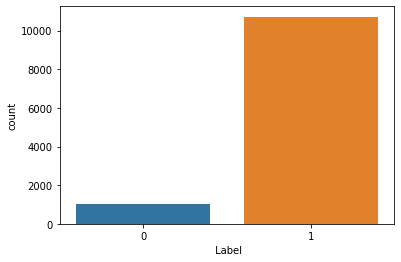

In [ ]:
sns.countplot(x=' Label',data=df1)

#Imbalanced data visulization for Multiclass

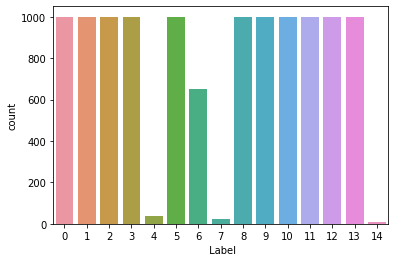

In [ ]:
sns.countplot(x=' Label',data=df)

In [ ]:
df.replace([np.inf,-np.inf,np.nan], 0.0, inplace=True)

#Multiple Class Classification Probelom

In [ ]:
real_x = df.iloc[:,:-1]
real_y = df.iloc[:,-1]

#feature Scalling using Min Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler as Scaler
scaler=Scaler()
scaler.fit(real_x)
ids_scaled=scaler.transform(real_x)

In [ ]:
X_new=pd.DataFrame(data=ids_scaled)

In [ ]:
X_new.columns=[' Source IP', ' Source Port', ' Destination IP',' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',' Total Fwd Packets',
             ' Total Backward Packets','Total Length of Fwd Packets', ' Total Length of Bwd Packets',' Fwd Packet Length Max', ' Fwd Packet Length Min',
             ' Fwd Packet Length Mean', ' Fwd Packet Length Std','Bwd Packet Length Max', ' Bwd Packet Length Min',' Bwd Packet Length Mean', 
             ' Bwd Packet Length Std', 'Flow Bytes/s',' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',' Flow IAT Min', 
             'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',' Bwd IAT Std', 
             ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',' Fwd Header Length', 
             ' Bwd Header Length', 'Fwd Packets/s',' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',' Packet Length Mean', 
             ' Packet Length Std', ' Packet Length Variance','FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',' PSH Flag Count', ' ACK Flag Count', 
             ' URG Flag Count',' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio',' Average Packet Size', ' Avg Fwd Segment Size',' Avg Bwd Segment Size', 
             ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',' Bwd Avg Packets/Bulk', 
             'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes','Init_Win_bytes_forward', 
             ' Init_Win_bytes_backward',' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean',' Active Std', ' Active Max', ' Active Min', 'Idle Mean', 
             ' Idle Std',' Idle Max', ' Idle Min']
X_new.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,...,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.449941,0.006760,0.869272,0.842405,0.352941,0.996692,2.500100e-08,0.000181,0.000000,0.000004,0.000000e+00,0.000257,0.025974,0.00101,0.0,0.000000,0.000000,0.000000,0.0,0.006483,0.222222,9.009009e-08,0.0,2.586207e-08,3.125000e-07,2.500000e-08,3.000000e-08,0.0,2.586207e-08,3.000000e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000362,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.004644,0.00101,0.000000,0.000362,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,0.000004,0.000000,0.000000e+00,0.000519,0.000000,0.000181,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.449928,0.001221,0.869272,0.845307,0.352941,0.996692,9.083698e-07,0.000000,0.000181,0.000002,7.611864e-07,0.000257,0.025974,0.00101,0.0,0.000345,0.016854,0.001373,0.0,0.000178,0.006116,3.273273e-06,0.0,9.396552e-07,8.593749e-06,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.004644,0.00101,0.001373,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.000181,7.611864e-07,0.000458,0.003922,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.449928,0.001221,0.869272,0.845322,0.352941,0.996692,4.333507e-07,0.000000,0.000181,0.000002,7.611864e-07,0.000257,0.025974,0.00101,0.0,0.000345,0.016854,0.001373,0.0,0.000374,0.012821,1.561562e-06,0.0,4.482759e-07,4.140625e-06,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.004644,0.00101,0.001373,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.000181,7.611864e-07,0.000458,0.003922,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.449962,0.006760,0.869272,0.709914,0.352941,0.996692,2.833447e-07,0.000000,0.000181,0.000002,7.611864e-07,0.000257,0.025974,0.00101,0.0,0.000345,0.016854,0.001373,0.0,0.000572,0.019608,1.021021e-06,0.0,2.931034e-07,2.734375e-06,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.004644,0.00101,0.001373,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.000181,7.611864e-07,0.000488,0.005035,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.449995,0.006760,0.869272,0.842374,0.352941,0.996692,2.500100e-08,0.000181,0.000000,0.000004,0.000000e+00,0.000257,0.025974,0.00101,0.0,0.000000,0.000000,0.000000,0.0,0.006483,0.222222,9.009009e-08,0.0,2.586207e-08,3.125000e-07,2.500000e-08,3.000000e-08,0.0,2.586207e-08,3.000000e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000362,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0

#Feature Selection Using Univarent

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_update=SelectKBest(score_func=chi2,k=60).fit_transform(X_new,real_y)

#Feature Importance

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(real_x,real_y)
print(model.feature_importances_)

[1.57930786e-02 4.76699648e-02 2.22977112e-03 2.70109686e-02
 1.00540622e-02 1.47740904e-01 1.60397994e-02 6.90724469e-03
 7.54049222e-03 7.18596732e-03 6.21065625e-03 1.15653952e-02
 1.24888265e-02 8.06775958e-03 8.74989283e-03 2.09853473e-02
 1.03592262e-02 1.68044158e-02 1.39506688e-02 1.64784116e-03
 6.06108396e-03 1.44698406e-02 1.77076696e-02 1.36261520e-02
 8.34090022e-03 1.59966748e-02 1.37600473e-02 2.01550615e-02
 1.50073254e-02 7.60162704e-03 5.66343798e-03 8.64030730e-03
 1.04244355e-02 8.16811670e-03 1.13510054e-03 1.24820803e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.97037597e-03
 1.18494789e-02 5.23717184e-03 7.98490597e-03 1.64242320e-02
 1.15115391e-02 1.87497284e-02 1.33657091e-02 8.26391291e-03
 1.08357989e-04 1.24331728e-02 0.00000000e+00 2.30355121e-02
 1.78986418e-02 1.70120628e-02 0.00000000e+00 0.00000000e+00
 1.99890667e-02 2.09005553e-02 6.15128490e-03 1.85375835e-02
 7.82179230e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

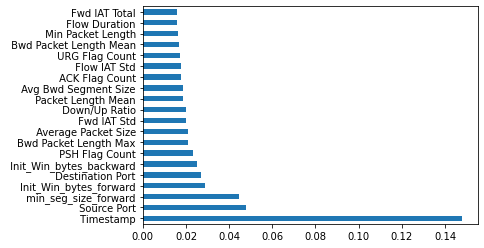

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=real_x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
# corr = df.corr()
# corr

In [ ]:
# %matplotlib inline
# import seaborn as sns#Seaborn is a Python data visualization library based on matplotlib. 
# #It provides a high-level interface for drawing attractive and informative statistical graphics.
# sns.heatmap(corr, annot = True)

#Correlation Matrix with HeatMap

In [ ]:
corr = df.corr()
top_corr_features = corr.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap='gist_heat')

In [ ]:
plt.savefig('cmp.png')

<Figure size 432x288 with 0 Axes>

#Oversampling with Balanced the data set using Random Over sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
X_over, y_over = oversample.fit_sample(X_update, real_y)

In [ ]:
df2 = pd.DataFrame(y_over)
df2.columns=[' Label']

#Balanced the Data set

In [ ]:
df2[' Label'].value_counts() 

7     1000
14    1000
6     1000
13    1000
5     1000
12    1000
4     1000
11    1000
3     1000
10    1000
2     1000
9     1000
1     1000
8     1000
0     1000
Name:  Label, dtype: int64

In [ ]:
df2.shape

(15000, 1)

#Visulization with Target Multiclass

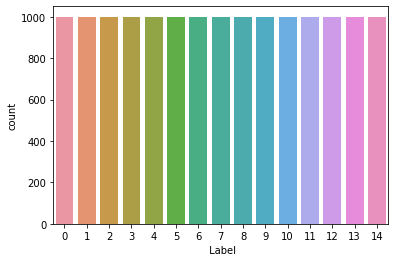

In [ ]:
sns.countplot(x=' Label',data=df2)

#Spliting the Data set using train test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
training_x, test_x, training_y, test_y = train_test_split(X_over, y_over, test_size=0.3, random_state=0)

In [ ]:
training_x.shape

(10500, 60)

In [ ]:
test_x.shape

(4500, 60)

In [ ]:
training_y.shape

(10500,)

#Hyper Parameter tuning With RandomizedSearchCV

#Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rfc = RandomForestClassifier()
params =  {'bootstrap': [True, False],
         'max_depth': [5,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
rfc_random = hypertuning_rscv(rfc,params,50,X_over, y_over)
rfc_random

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
rfc = RandomForestClassifier(bootstrap=True,max_depth=None,max_features='auto',min_samples_leaf=2,min_samples_split=2,
                             n_estimators=200)
kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(rfc,X_over,y_over,cv=kfold)
results

array([0.89933333, 0.988     , 0.98733333, 0.96866667, 0.98466667,
       0.99066667, 0.96733333, 0.992     , 0.98733333, 0.96333333])

In [ ]:
results.mean()

0.9728666666666668

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
lr = LogisticRegression()
params = {'penalty': ['l1','l2'],
          'C':[1.0,2.0,3.0,4.0],
          'fit_intercept':[True],
          'intercept_scaling':[1.0],
          'random_state':[None],
          'solver':['lbfgs'],
          'n_jobs': [-1]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
rfc_random = hypertuning_rscv(lr,params,50,X_over, y_over)
rfc_random

{'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs'}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(C=1.0,fit_intercept=True,intercept_scaling=1.0,n_jobs=-1,
                        penalty='l2',random_state=50,solver='lbfgs')

kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(lr,X_over,y_over,cv=kfold)
results

array([0.858     , 0.93333333, 0.91      , 0.91066667, 0.90533333,
       0.86666667, 0.89266667, 0.894     , 0.91466667, 0.86866667])

In [ ]:
results.mean()

0.8953999999999999

#SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
import random 
from scipy.stats import randint, norm, uniform

In [ ]:
sgd = SGDClassifier()
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

In [ ]:
def hypertuning_rscv(sgd, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(sgd, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
rfc_random = hypertuning_rscv(sgd,params,50,X_over, y_over)
rfc_random

{'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
sgd = SGDClassifier(epsilon=0.1,eta0=0.0,loss='hinge',max_iter=1000,penalty='l2',shuffle=True)

kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(sgd,X_over,y_over,cv=kfold)
results

array([0.90333333, 0.91666667, 0.90133333, 0.89      , 0.894     ,
       0.858     , 0.878     , 0.88666667, 0.91866667, 0.91      ])

In [ ]:
results.mean()

0.8956666666666667

#AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
ada = AdaBoostClassifier()
params = {'algorithm':['SAMME.R'],
          'learning_rate':[5.0],
          'n_estimators':[500],
          'random_state':[50]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
ada_random = hypertuning_rscv(ada,params,50,X_over, y_over)
ada_random

{'algorithm': 'SAMME.R',
 'learning_rate': 5.0,
 'n_estimators': 500,
 'random_state': 50}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
ada = AdaBoostClassifier(algorithm='SAMME.R',learning_rate=5.0,n_estimators=500,random_state=50)

kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(ada,X_over,y_over,cv=kfold)
results

array([0.95      , 0.976     , 0.92333333, 0.98733333, 0.98533333,
       0.916     , 0.96266667, 0.99666667, 0.918     , 0.93333333])

In [ ]:
results.mean()

0.9548666666666668

#XGBoost Classifier

In [ ]:
import xgboost as xgb
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
xg = xgb.XGBClassifier()
params = {'base_score': [0.5],
          'booster': ['dart'],
          "colsample_bytree" : [ 0.0],
          'gamma':[0.1],
          'learning_rate':[1.5],
          'max_depth':[6]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
xg_random = hypertuning_rscv(xg,params,50,X_over, y_over)
xg_random

{'base_score': 0.5,
 'booster': 'dart',
 'colsample_bytree': 0.0,
 'gamma': 0.1,
 'learning_rate': 1.5,
 'max_depth': 6}

In [ ]:
xg = xgb.XGBClassifier()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
xg = xgb.XGBClassifier(base_score=0.5,booster='dart',colsample_bytree=0.0,gamma=0.1,
                       learning_rate=1.5,max_depth=6)
kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(xg,X_over,y_over,cv=kfold)
results

array([0.94266667, 0.99466667, 0.994     , 0.99133333, 0.99266667,
       0.99066667, 0.99866667, 0.99533333, 0.99      , 0.98333333])

In [ ]:
results.mean()

0.9873333333333332

#Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
DT = DecisionTreeClassifier()
params = {"max_depth": [1, None],
          "max_features": randint(1, 9),
          "min_samples_leaf": randint(1, 9),
          "criterion": ["gini", "entropy"]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
DT_random = hypertuning_rscv(DT,params,50,X_over, y_over)
DT_random

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 8}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
DT = DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features=5,min_samples_leaf=8)

kfold=StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
results=cross_val_score(DT,X_over,y_over,cv=kfold)
results

array([0.876     , 0.97      , 0.96733333, 0.95133333, 0.97266667,
       0.87      , 0.93866667, 0.91733333, 0.94466667, 0.95333333])

In [ ]:
results.mean()

0.9361333333333333

#KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
knn = KNeighborsClassifier()
params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
DT_random = hypertuning_rscv(knn,params,50,X_over, y_over)
DT_random

{'algorithm': 'brute',
 'leaf_size': 2,
 'n_jobs': -1,
 'n_neighbors': 7,
 'weights': 'distance'}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_jobs=-1,n_neighbors=5,weights='distance')

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(knn,X_over,y_over,cv=kfold)
results

array([0.90533333, 0.98066667, 0.97733333, 0.92266667, 0.90866667,
       0.92133333, 0.92933333, 0.93333333, 0.95466667, 0.98066667])

In [ ]:
results.mean()

0.9414

#BernouliNB Classifier Without Hyper Tuning

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
bnb = BernoulliNB()
params = {'alpha':[0.0,1.0],'binarize':[0.0],'fit_prior':bool}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
bnb = BernoulliNB(alpha=3.0,binarize=0.0,fit_prior=True,class_prior=None)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(bnb,X_over,y_over,cv=kfold)
results

array([0.41266667, 0.53466667, 0.55333333, 0.544     , 0.61133333,
       0.53666667, 0.50866667, 0.53666667, 0.56133333, 0.58466667])

In [ ]:
results.mean()

0.5384

#MultinomialNB Without Hyper Tuning

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
mnb=MultinomialNB(alpha=1.0,fit_prior=True,class_prior=None)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(mnb,X_over,y_over,cv=kfold)
results

array([0.536     , 0.62133333, 0.57      , 0.58333333, 0.67933333,
       0.70733333, 0.704     , 0.64      , 0.66      , 0.64266667])

In [ ]:
results.mean()

0.6344000000000001

#GaussionNB without Hyper Tuning

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
gnb=GaussianNB(var_smoothing=1e-7)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(gnb,X_over,y_over,cv=kfold)
results

array([0.93666667, 0.94333333, 0.928     , 0.93      , 0.928     ,
       0.942     , 0.94      , 0.92666667, 0.936     , 0.91066667])

In [ ]:
results.mean()

0.9321333333333334

#SVC Classifier

In [ ]:
from sklearn.svm import SVC 
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
svc = SVC()
params = {'C': [6,7,8,9,10,11,12], 
          'kernel': ['linear','rbf']}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
svc_random = hypertuning_rscv(svc,params,50,X_over, y_over)
svc_random

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
svc=SVC(kernel='rbf',C=12.0,degree=500)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(svc,X_over,y_over,cv=kfold)
results

array([0.91866667, 0.996     , 0.978     , 0.94066667, 0.91066667,
       0.87666667, 0.90666667, 0.92266667, 0.966     , 0.91866667])

In [ ]:
results.mean()

0.9334666666666666

#Bulid all model in Single Block with Multiclass

In [ ]:
from sklearn.svm import SVC                       
svc=SVC(kernel='rbf',C=12.0,degree=500)

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(penalty='l2',C=1.0,fit_intercept=True,intercept_scaling=1,random_state=None)

from xgboost import XGBClassifier
xg=XGBClassifier(base_score=0.5,booster='dart',colsample_bytree=0.0,gamma=0.1,
                       learning_rate=1.5,max_depth=6)


from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha=1.0,fit_prior=True,class_prior=None)

from sklearn.naive_bayes import BernoulliNB
bnb=BernoulliNB(alpha=3.0,binarize=0.0,fit_prior=True,class_prior=None)

from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB(var_smoothing=1e-7)

from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss="hinge", penalty="l1")

from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(algorithm='brute',leaf_size=1,n_jobs=-1,n_neighbors=5,weights='distance')

from sklearn.ensemble import RandomForestClassifier            
rfc=RandomForestClassifier(bootstrap=True,max_depth=8,max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=200)

from sklearn.tree import DecisionTreeClassifier 
DT=DecisionTreeClassifier(criterion='entropy',max_depth=None,max_features=5,min_samples_leaf=8)

                                

#All model define in a Dictionary

In [ ]:
classifiers={'LogisticRegression':lr,'BernoulliNB':bnb,'GaussianNB':gnb,'RandomForestClassifier':rfc,'SVC': svc,'DecisionTreeClassifier': DT,'KNeighborsClassifier':knn
        , 'MultinomialNB':mnb,'XGBClassifier':xg,'SGDClassifier':sgd }

In [ ]:
classifie=sorted(classifiers.keys())
print(classifie)
df=pd.DataFrame(classifie,columns=['Classifiers'])
df

['BernoulliNB', 'DecisionTreeClassifier', 'GaussianNB', 'KNeighborsClassifier', 'LogisticRegression', 'MultinomialNB', 'RandomForestClassifier', 'SGDClassifier', 'SVC', 'XGBClassifier']


,Classifiers
0,BernoulliNB
1,DecisionTreeClassifier
2,GaussianNB
3,KNeighborsClassifier
4,LogisticRegression
5,MultinomialNB
6,RandomForestClassifier
7,SGDClassifier
8,SVC
9,XGBClassifier


#Best Results of all Classifier

In [ ]:
parameter=[]
res=[]                                 
res=pd.DataFrame(res)
for n,c in sorted(classifiers.items()):                   
    kfold=StratifiedKFold(n_splits=10,random_state=None)  
    results=cross_val_score(c,X_over,y_over,cv=kfold)      
    parameter.append((n,[results.mean()]))                
    result=pd.DataFrame(results)                          
    res=pd.concat([res,result],axis=1,ignore_index=True) 

res.columns=['BernoulliNB','DecisionTree','GaussianNB','KNeighbors','Logistic','MultinomialNB',
             'RandomForest','SGDClassifier','SVM','XGBoost']    
res 

,BernoulliNB,DecisionTree,GaussianNB,KNeighbors,Logistic,MultinomialNB,RandomForest,SGDClassifier,SVM,XGBoost
0,0.420000,0.844667,0.893333,0.908667,0.858000,0.536000,0.899333,0.870667,0.920667,0.940667
1,0.538667,0.983333,0.943333,0.979333,0.926667,0.635333,0.984667,0.989333,0.996000,0.994000
2,0.548667,0.915333,0.928000,0.982000,0.912000,0.570667,0.985333,0.925333,0.968667,0.988000
3,0.546667,0.965333,0.930000,0.917333,0.912000,0.586667,0.965333,0.912667,0.940667,0.990667
4,0.613333,0.936667,0.928000,0.900000,0.904000,0.674000,0.988667,0.902000,0.910667,0.062000
5,0.532000,0.922000,0.942000,0.923333,0.864000,0.701333,0.990667,0.864667,0.876667,0.992000
6,0.511333,0.992667,0.938667,0.933333,0.891333,0.703333,0.989333,0.887333,0.904667,0.998667
7,0.532667,0.888000,0.928000,0.934000,0.888667,0.624667,0.991333,0.901333,0.924000,0.996000
8,0.557333,0.932667,0.934667,0.954667,0.918667,0.643333,0.988667,0.920667,0.932000,0.992000
9,0.589333,0.949333,0.912000,0.980667,0.864000,0.642667,0.964000,0.915333,0.918667,0.984667


#Box Plot for all Models in Multiple Class

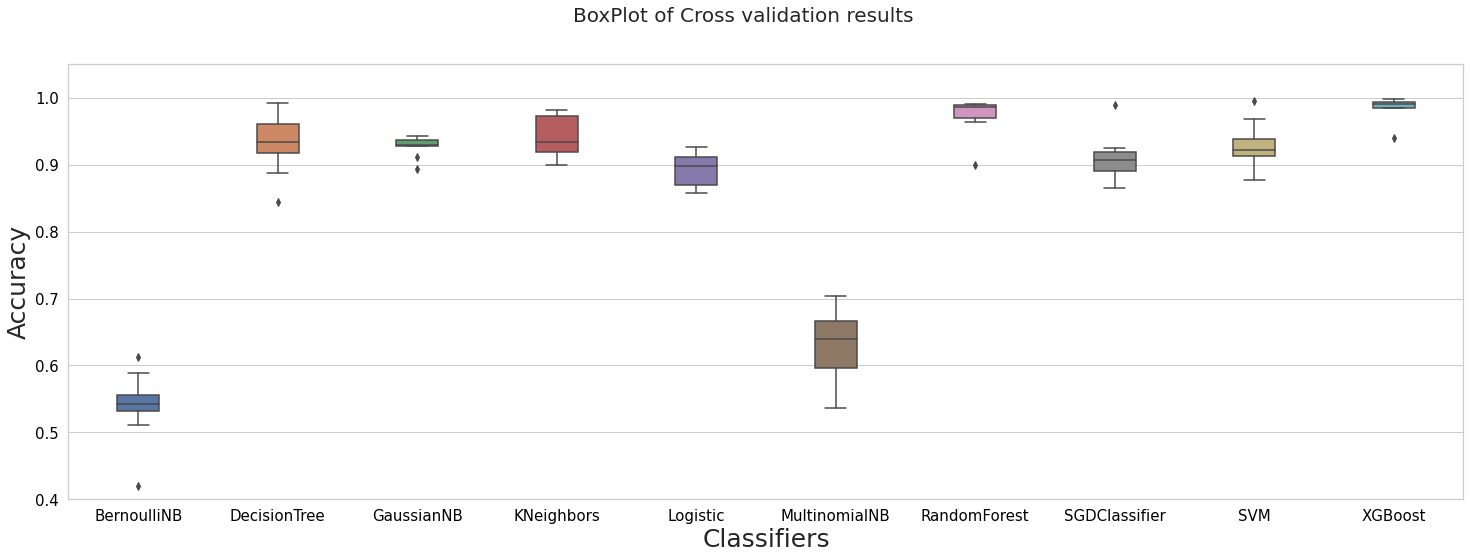

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.set(style="whitegrid")
boxplot=sns.boxplot(data=res,width=0.3)
boxplot.set_ylim([0.4,1.05])
fig.suptitle('BoxPlot of Cross validation results',fontsize=20)
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Classifiers',fontsize=25)
plt.tick_params(axis='both', which='major', colors='black', labelsize=15)
plt.show()

#Precesion recall, f1_score, Confusion Matrix

In [ ]:
score = []
i=1
for n,c in sorted(classifiers.items()):
    start=time.time()
    c.fit(training_x,training_y)
    pred=c.predict(test_x)
    end=time.time()
    print("{}) Classifier is : {}\n".format(i,c))
    print("Total time in : ",end-start)

    score.append((n,[accuracy_score(test_y,pred,normalize=True),metrics.precision_score(test_y,pred,average='micro'),
                    metrics.recall_score(test_y, pred,average='micro'),metrics.f1_score(test_y,pred,average='micro')]))
    
    print("\nConfusion_matrix is \n",confusion_matrix(test_y,pred))
    precision=print("\nPrecision : ",metrics.precision_score(test_y,pred,average='micro'))      
    recall=print("Recall    : ",metrics.recall_score(test_y,pred,average='micro'))
    f1_score=print("f1_score  : ",metrics.f1_score(test_y,pred,average='micro'))
    i=i+1                    

1) Classifier is : BernoulliNB(alpha=3.0, binarize=0.0, class_prior=None, fit_prior=True)

Total time in :  0.01871967315673828

Confusion_matrix is 
 [[ 61  17  58   6  20   2   1   1   7  12   0   0  87  14   3]
 [  0 133   0   0   0   0   0   0   0   0   0   0 183   3   0]
 [  0   0 241   0   0   0  26   0   0   3   0   0  11   4   7]
 [  0   0   0 154   0   0   0   0   0   0   0   0   6   0 136]
 [  0  20   0   8 228   0   0   0   0   0   0   0  24  37   0]
 [  0   0   0   0   0   0 211   0   0  22   0   0  18   0  19]
 [  0   0   0   0   0   0 295   0   0   3   0   0   1   0  11]
 [  0   0   0   0   0  10   0   0   0 115   0   0 118   0  53]
 [  0   0   0   0   0   0   0   0 142   1   0   0 148   0   0]
 [  0   0   0   0   0   5   2   0   9 138   0   0 149   0   3]
 [  0   2   0   3  10   0 105   0  45   1  90   0   0  67   0]
 [  0   0   0   0   0   0   0   0   0   0  83 205   0  12   0]
 [  0   0   0   0   0   1  67   0   0   0   0   0 243   0   1]
 [  0   0   0   0   0   0  14 

#Accuracy for all model For Multiple Class

In [ ]:
score_df=pd.DataFrame.from_dict(dict(score),orient='index',columns=['scores','Precision','Recall','f1_score'])
score_df['Accuracy (%)']=score_df['scores']*100
score_df                   

,scores,Precision,Recall,f1_score,Accuracy (%)
BernoulliNB,0.545333,0.545333,0.545333,0.545333,54.533333
DecisionTreeClassifier,0.948667,0.948667,0.948667,0.948667,94.866667
GaussianNB,0.940444,0.940444,0.940444,0.940444,94.044444
KNeighborsClassifier,0.972222,0.972222,0.972222,0.972222,97.222222
LogisticRegression,0.922667,0.922667,0.922667,0.922667,92.266667
MultinomialNB,0.645778,0.645778,0.645778,0.645778,64.577778
RandomForestClassifier,0.981778,0.981778,0.981778,0.981778,98.177778
SGDClassifier,0.927111,0.927111,0.927111,0.927111,92.711111
SVC,0.948667,0.948667,0.948667,0.948667,94.866667
XGBClassifier,0.995111,0.995111,0.995111,0.995111,99.511111


#Histogram Plot all Models in Multiple Class

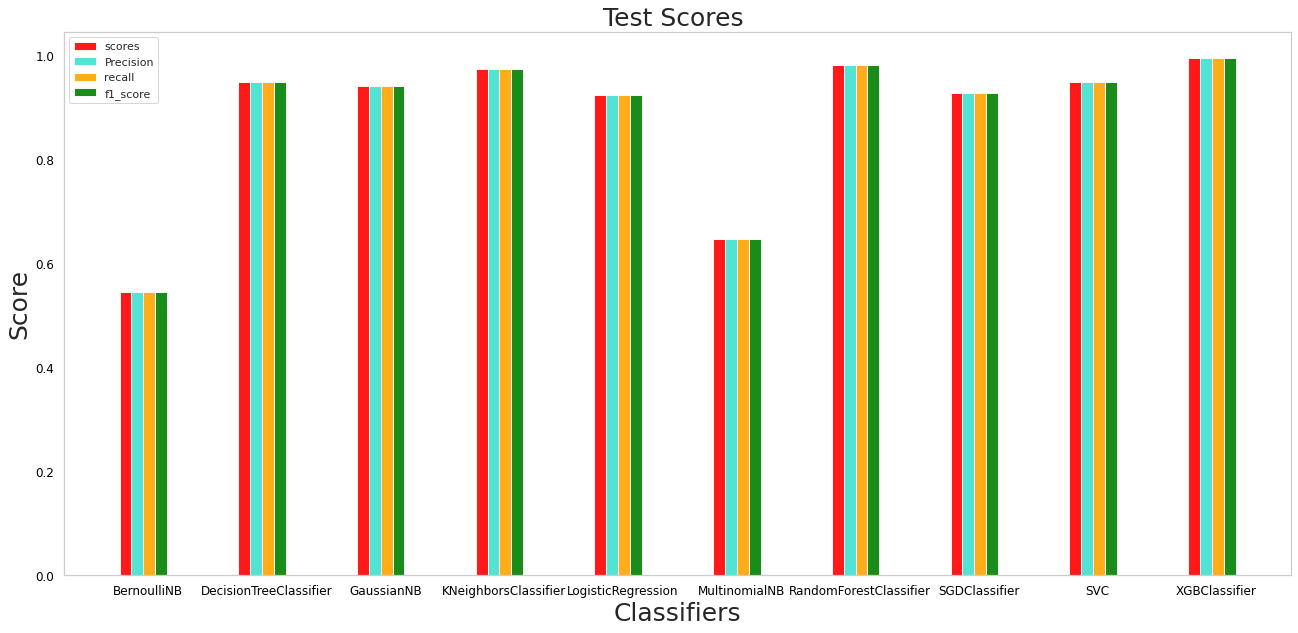

In [ ]:
pos = list(range(len(df['Classifiers']))) 
width = 0.10 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(22,10)) 
plt.bar(pos,score_df['scores'],width,alpha=0.9,color='red',label=score_df['scores'][0]) 
plt.bar([p + width for p in pos],score_df['Precision'],width,alpha=0.9,color='turquoise',label=score_df['Precision'][1]) 
plt.bar([p + width*2 for p in pos],score_df['Recall'],width,alpha=0.9, color='orange',label=score_df['Recall']) 
plt.bar([p + width*3 for p in pos],score_df['f1_score'],width,alpha=0.9, color='green',label=score_df['f1_score']) 
ax.set_ylabel('Score',fontsize=25)
ax.set_xlabel('Classifiers',fontsize=25)
ax.set_title('Test Scores ',fontsize=25)
ax.set_xticks([p + 1.9 * width for p in pos])
ax.set_xticklabels(df['Classifiers'])
plt.legend(['scores', 'Precision', 'recall','f1_score'], loc='upper left')
plt.grid()
plt.tick_params(axis='both', which='major', colors='black',labelsize=12)

plt.show()

# Binary Class Probelom

In [ ]:
real_x = df1.iloc[:,:-1]
real_y = df1.iloc[:,-1]

#Feature Scaling using MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler as Scaler
scaler=Scaler()
scaler.fit(real_x)
ids_scaled=scaler.transform(real_x)

In [ ]:
X_new=pd.DataFrame(data=ids_scaled)

In [ ]:
X_new.columns=[' Source IP', ' Source Port', ' Destination IP',' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',' Total Fwd Packets',
             ' Total Backward Packets','Total Length of Fwd Packets', ' Total Length of Bwd Packets',' Fwd Packet Length Max', ' Fwd Packet Length Min',
             ' Fwd Packet Length Mean', ' Fwd Packet Length Std','Bwd Packet Length Max', ' Bwd Packet Length Min',' Bwd Packet Length Mean', 
             ' Bwd Packet Length Std', 'Flow Bytes/s',' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',' Flow IAT Min', 
             'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',' Bwd IAT Std', 
             ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',' Fwd Header Length', 
             ' Bwd Header Length', 'Fwd Packets/s',' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',' Packet Length Mean', 
             ' Packet Length Std', ' Packet Length Variance','FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',' PSH Flag Count', ' ACK Flag Count', 
             ' URG Flag Count',' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio',' Average Packet Size', ' Avg Fwd Segment Size',' Avg Bwd Segment Size', 
             ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',' Bwd Avg Packets/Bulk', 
             'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes','Init_Win_bytes_forward', 
             ' Init_Win_bytes_backward',' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean',' Active Std', ' Active Max', ' Active Min', 'Idle Mean', 
             ' Idle Std',' Idle Max', ' Idle Min']
X_new.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,...,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.449941,0.006760,0.869272,0.842405,0.352941,0.996692,2.500100e-08,0.000181,0.000000,0.000004,0.000000e+00,0.000257,0.025974,0.00101,0.0,0.000000,0.000000,0.000000,0.0,0.006483,0.222222,9.009009e-08,0.0,2.586207e-08,3.125000e-07,2.500000e-08,3.000000e-08,0.0,2.586207e-08,3.000000e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000362,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.004644,0.00101,0.000000,0.000362,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,0.000004,0.000000,0.000000e+00,0.000519,0.000000,0.000181,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.449928,0.001221,0.869272,0.845307,0.352941,0.996692,9.083698e-07,0.000000,0.000181,0.000002,7.611864e-07,0.000257,0.025974,0.00101,0.0,0.000345,0.016854,0.001373,0.0,0.000178,0.006116,3.273273e-06,0.0,9.396552e-07,8.593749e-06,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.004644,0.00101,0.001373,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.000181,7.611864e-07,0.000458,0.003922,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.449928,0.001221,0.869272,0.845322,0.352941,0.996692,4.333507e-07,0.000000,0.000181,0.000002,7.611864e-07,0.000257,0.025974,0.00101,0.0,0.000345,0.016854,0.001373,0.0,0.000374,0.012821,1.561562e-06,0.0,4.482759e-07,4.140625e-06,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.004644,0.00101,0.001373,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.000181,7.611864e-07,0.000458,0.003922,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.449962,0.006760,0.869272,0.709914,0.352941,0.996692,2.833447e-07,0.000000,0.000181,0.000002,7.611864e-07,0.000257,0.025974,0.00101,0.0,0.000345,0.016854,0.001373,0.0,0.000572,0.019608,1.021021e-06,0.0,2.931034e-07,2.734375e-06,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000181,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.333333,0.004644,0.00101,0.001373,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.000181,7.611864e-07,0.000488,0.005035,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.449995,0.006760,0.869272,0.842374,0.352941,0.996692,2.500100e-08,0.000181,0.000000,0.000004,0.000000e+00,0.000257,0.025974,0.00101,0.0,0.000000,0.000000,0.000000,0.0,0.006483,0.222222,9.009009e-08,0.0,2.586207e-08,3.125000e-07,2.500000e-08,3.000000e-08,0.0,2.586207e-08,3.000000e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000362,...,0.06383,0.000257,0.003338,0.0,0.0,0.0,0.0,0.0,0.0,1.0

#Feature Selection with Univariate Selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_update=SelectKBest(score_func=chi2,k=60).fit_transform(X_new,real_y)

#Feature Importance

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(real_x,real_y)
print(model.feature_importances_)

[0.06724107 0.01753608 0.01491275 0.03606072 0.12677253 0.08003676
 0.00663466 0.00820092 0.0057838  0.00233079 0.00815532 0.00513159
 0.04667153 0.00338021 0.00271013 0.00981026 0.06706081 0.01909651
 0.0292532  0.00420756 0.00576174 0.00559806 0.00335519 0.0047738
 0.00607176 0.00429621 0.00339278 0.00284141 0.0036279  0.00291408
 0.00328126 0.00354493 0.00333388 0.00256707 0.00185317 0.00489711
 0.         0.         0.         0.00537594 0.00723965 0.00489928
 0.00599834 0.06806809 0.00641921 0.01569885 0.01045481 0.00791812
 0.00598853 0.00622199 0.         0.02764833 0.02140165 0.00865344
 0.         0.         0.01687218 0.01624676 0.00415187 0.02005857
 0.00448939 0.         0.         0.         0.         0.
 0.         0.01382336 0.00595248 0.00618498 0.00864519 0.03106866
 0.01128299 0.00469959 0.02465381 0.00090549 0.00056154 0.00114561
 0.00047231 0.0014827  0.00034181 0.00107763 0.00079929]


#Plot Graph for Feature Importance with better Visulizaton

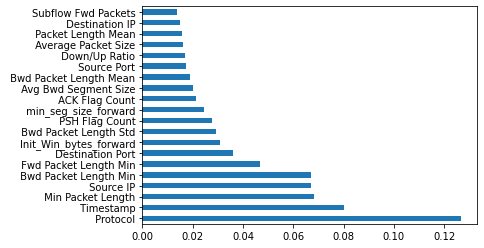

In [ ]:
feat_importances = pd.Series(model.feature_importances_,index=real_x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

#Correlation Matrics with HeatMap

In [ ]:
corr = df1.corr()

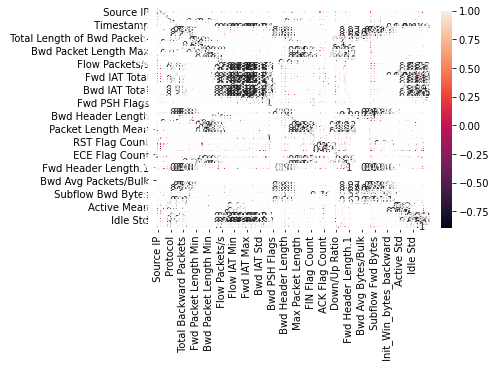

In [ ]:
plt.figure(figsize=(30,30))
%matplotlib inline
import seaborn as sns#Seaborn is a Python data visualization library based on matplotlib. 
#It provides a high-level interface for drawing attractive and informative statistical graphics.
sns.heatmap(corr, annot = True)

#RandomOver Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
X_over, y_over = oversample.fit_sample(X_update, real_y)

In [ ]:
df3 = pd.DataFrame(y_over)
df3.columns=[' Label']

In [ ]:
df3[' Label'].value_counts()

1    10720
0    10720
Name:  Label, dtype: int64

#Visulization Target with Balanced Data with Binary Class

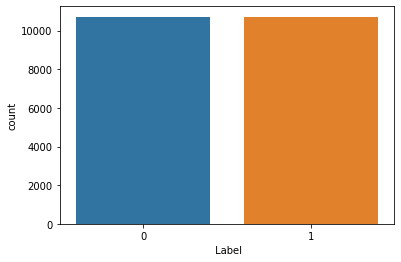

In [ ]:
sns.countplot(x=' Label',data=df3)

#Spliting the Data Set

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
training_x, test_x, training_y, test_y = train_test_split(X_over,y_over, test_size=0.3, random_state=0)

#Hyper parameter tuning with RandomizedSearchCV

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
lr = LogisticRegression() 
params =[    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(5, 9, 30),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000]
    }
]

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
lr_random = hypertuning_rscv(lr,params,50,X_over, y_over)
lr_random

{'C': 672335.7536499335, 'max_iter': 100, 'penalty': 'none', 'solver': 'sag'}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(C=672335.7536499335,max_iter=100,penalty='none',solver='sag')

kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(lr,X_over,y_over,cv=kfold)
results

array([0.89225746, 0.70009328, 0.98600746, 0.98647388, 0.9869403 ,
       0.98414179, 0.98927239, 0.98927239, 0.98787313, 0.7448694 ])

In [ ]:
results.mean()

0.9247201492537315

#KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
knn = KNeighborsClassifier()
params = {'n_neighbors':[5,10,15,20,25],
          'leaf_size':[1,2,3,5,6,7,8,9,10,11,12,13,14,15],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
knn_random = hypertuning_rscv(knn,params,50,X_over, y_over)
knn_random

{'algorithm': 'kd_tree',
 'leaf_size': 10,
 'n_jobs': -1,
 'n_neighbors': 20,
 'weights': 'uniform'}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=10,n_jobs=-1, n_neighbors=20,weights='uniform')
kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(knn,X_over,y_over,cv=kfold)
results

array([0.54104478, 0.93423507, 0.99906716, 0.99906716, 0.99953358,
       0.99766791, 0.98647388, 0.99813433, 0.99860075, 0.72061567])

In [ ]:
results.mean()

0.9174440298507462

#Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
DT = DecisionTreeClassifier()
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [5,10,15,20,25,30,35,40,50], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
          'random_state':[10]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
DT_random = hypertuning_rscv(DT,params,50,X_over, y_over)
DT_random

{'max_features': 'log2',
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'random_state': 10}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
DT = DecisionTreeClassifier(max_features='log2',min_samples_leaf=15,min_samples_split=5,random_state=10)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(DT,X_over,y_over,cv=kfold)
results

array([0.55270522, 0.95242537, 0.99906716, 0.98927239, 0.9869403 ,
       0.99347015, 0.91511194, 0.97714552, 0.99813433, 0.57089552])

In [ ]:
results.mean()

0.8935167910447761

#GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
gnb=GaussianNB()
params = {'var_smoothing':[1e-01]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
gnb_random = hypertuning_rscv(gnb,params,50,X_over, y_over)
gnb_random

{'var_smoothing': 0.1}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
gnb=GaussianNB(var_smoothing=0.1)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(gnb,X_over,y_over,cv=kfold)
results

array([0.46641791, 0.5443097 , 0.96595149, 0.95615672, 0.96455224,
       0.95522388, 0.91884328, 0.94123134, 0.95102612, 0.51585821])

In [ ]:
results.mean()

0.8179570895522387

#Multinomial

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
mnb=MultinomialNB()
params = {'alpha':[1.0],
          'fit_prior':[True],
          'class_prior':[None]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
mnb=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(mnb,X_over,y_over,cv=kfold)
results

array([0.53404851, 0.51259328, 0.92537313, 0.78264925, 0.8386194 ,
       0.89972015, 0.77518657, 0.53218284, 0.85820896, 0.47994403])

In [ ]:
results.mean()

0.7138526119402986

#BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
bnb=BernoulliNB(binarize=0.1,fit_prior=True,alpha=1.0)
kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(bnb,X_over,y_over,cv=kfold)
results

array([0.56902985, 0.73227612, 0.88059701, 0.92070896, 0.94123134,
       0.91744403, 0.87453358, 0.8255597 , 0.82369403, 0.74906716])

In [ ]:
results.mean()

0.8234141791044778

#SVC Classifier

In [ ]:
from sklearn.svm import SVC 
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
svc=SVC()
params = {"C": stats.uniform(100, 200),
          "gamma": stats.uniform(0.1, 0.2)}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
svc_random = hypertuning_rscv(svc,params,50,X_over, y_over)
svc_random

{'C': 147.69364053903945, 'gamma': 0.25688128005818256}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
svc=SVC(C=147.69364053903945,gamma=0.25688128005818256)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(svc,X_over,y_over,cv=kfold)
results

array([0.65671642, 0.82789179, 0.99440299, 0.99626866, 0.99860075,
       0.99533582, 0.9948694 , 0.99766791, 0.99533582, 0.78171642])

In [ ]:
results.mean()

0.9238805970149253

#SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
sgd = SGDClassifier()
params = {
    "loss" : ["modified_huber"],
    "penalty" : ["l1"]
}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
sgd_random = hypertuning_rscv(sgd,params,50,X_over, y_over)
sgd_random

{'loss': 'modified_huber', 'penalty': 'l1'}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
sgd=SGDClassifier(loss="modified_huber",penalty='l1')

kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(sgd,X_over,y_over,cv=kfold)
results

array([0.61567164, 0.58628731, 0.97621269, 0.98041045, 0.98460821,
       0.97108209, 0.98554104, 0.98320896, 0.97854478, 0.7551306 ])

In [ ]:
results.mean()

0.881669776119403

#Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

In [ ]:
rfc = RandomForestClassifier()
params = {'bootstrap': [True, False],
          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2, 4],
          'min_samples_split': [2, 5, 10],
          'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
rfc_random = hypertuning_rscv(rfc,params,50,X_over, y_over)
rfc_random

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
rfc = RandomForestClassifier(bootstrap=False,max_depth=4,max_features='auto',min_samples_leaf=1,
                             min_samples_split=5,n_estimators=200)
                            
kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(rfc,X_over,y_over,cv=kfold)
results

array([0.7943097 , 0.70102612, 0.99673507, 0.98460821, 0.99347015,
       0.9920709 , 0.99160448, 0.99160448, 0.99253731, 0.77238806])

In [ ]:
results.mean()

0.9210354477611942

#AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
ada = AdaBoostClassifier()
params = {'base_estimator':[None],
          'n_estimators':[50,100,150,200,250,300],
          'learning_rate':[0.0001,0.001,0.01,0.1],
          'algorithm':['SAMME','SAMME.R']}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
ada_random = hypertuning_rscv(ada,params,50,X_over, y_over)
ada_random

{'algorithm': 'SAMME',
 'base_estimator': None,
 'learning_rate': 0.0001,
 'n_estimators': 50,
 'random_state': None}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
ada = AdaBoostClassifier(algorithm='SAMME',base_estimator=None,learning_rate=2.0,n_estimators=500,random_state=None)

kfold=StratifiedKFold(n_splits=10,random_state=0)
results=cross_val_score(ada,X_over,y_over,cv=kfold)
results

array([0.73460821, 0.73414179, 0.74113806, 0.73880597, 0.71595149,
       0.74393657, 0.73320896, 0.76865672, 0.72341418, 0.53358209])

In [ ]:
results.mean()

0.7167444029850747

#XGBoost Classifier

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
xg = xgb.XGBClassifier()
params = {"learning_rate": [0.1, 0.01, 0.001],
          "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
          "max_depth": [10,20,30,40,50,60,70,80,90,100],
          "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
          "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
          "reg_alpha": [0, 0.5, 1],
          "reg_lambda": [1, 1.5, 2, 3, 4.5],
          "min_child_weight": [1, 3, 5, 7],
          "n_estimators": [50,100,200,300,400,500,600,700,800]}

In [ ]:
def hypertuning_rscv(rfc, p_distr, nbr_iter,training_x,training_y):
  rdmsearch =RandomizedSearchCV(rfc, param_distributions=p_distr,
                                n_jobs=-1, n_iter=nbr_iter, cv=5)
  rdmsearch.fit(real_x,real_y)
  ht_params = rdmsearch.best_params_
  return ht_params

In [ ]:
xg_random = hypertuning_rscv(xg,params,50,X_over, y_over)
xg_random

{'colsample_bytree': 0.3,
 'gamma': 0.01,
 'learning_rate': 0.001,
 'max_depth': 80,
 'min_child_weight': 7,
 'n_estimators': 700,
 'reg_alpha': 1,
 'reg_lambda': 2,
 'subsample': 0.2}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
xg = xgb.XGBClassifier(colsample_bytree=0.3,gamma=0.01,learning_rate=0.001,max_depth=80,min_child_weight=7,
                       n_estimators=700, reg_alpha=1,reg_lambda=2, subsample=0.2)

kfold=StratifiedKFold(n_splits=10,random_state=None)
results=cross_val_score(xg,X_over,y_over,cv=kfold)
results 

array([0.58675373, 0.95942164, 0.99860075, 0.99953358, 0.99906716,
       0.99860075, 0.99953358, 0.99720149, 0.99720149, 0.61473881])

In [ ]:
results.mean()

0.9150652985074625

#Build all model in Single Bloack with Binary Class

In [ ]:
from sklearn.svm import SVC                      
svc=SVC(C=107.39744591847008,gamma=0.20645183034398634)

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(C=672335.7536499335,max_iter=100,penalty='none',solver='sag')

from xgboost import XGBClassifier
xg=XGBClassifier(colsample_bytree=0.3,gamma=0.01,learning_rate=0.001,max_depth=80,min_child_weight=7,
                       n_estimators=700, reg_alpha=1,reg_lambda=2, subsample=0.2)


from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

from sklearn.naive_bayes import BernoulliNB
bnb=BernoulliNB(binarize=0.1,fit_prior=True,alpha=1.0)

from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB(var_smoothing=0.1)

from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss="modified_huber",penalty='l1')

from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(algorithm='kd_tree', leaf_size=10,n_jobs=-1, n_neighbors=20,weights='uniform')

from sklearn.ensemble import RandomForestClassifier            
rfc=RandomForestClassifier(bootstrap=False,max_depth=4,max_features='auto',min_samples_leaf=1,
                             min_samples_split=5,n_estimators=200)

from sklearn.tree import DecisionTreeClassifier 
DT=DecisionTreeClassifier(max_features='log2',min_samples_leaf=15,min_samples_split=5,random_state=10)

                                

#All Model define in Dictnary

In [ ]:
classifiers={'LogisticRegression':lr,'MultinomialNB':mnb,'GaussianNB':gnb,'BernoulliNB':mnb,'RandomForestClassifier':rfc,'SVC': svc,'DecisionTreeClassifier': DT,'KNeighborsClassifier':knn
        , 'XGBClassifier':xg,'SGDClassifier':sgd }
classifie=sorted(classifiers.keys())
print(classifie)
df1=pd.DataFrame(classifie,columns=['Classifiers'])
df1

['BernoulliNB', 'DecisionTreeClassifier', 'GaussianNB', 'KNeighborsClassifier', 'LogisticRegression', 'MultinomialNB', 'RandomForestClassifier', 'SGDClassifier', 'SVC', 'XGBClassifier']


,Classifiers
0,BernoulliNB
1,DecisionTreeClassifier
2,GaussianNB
3,KNeighborsClassifier
4,LogisticRegression
5,MultinomialNB
6,RandomForestClassifier
7,SGDClassifier
8,SVC
9,XGBClassifier


#Results all classifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
parameter=[]
res=[]                                 

res=pd.DataFrame(res)
for n,c in sorted(classifiers.items()):                   
    kfold=StratifiedKFold(n_splits=10,random_state=None)  
    results=cross_val_score(c,X_over,y_over,cv=kfold)      
    parameter.append((n,[results.mean()]))                
    result=pd.DataFrame(results)                          
    res=pd.concat([res,result],axis=1,ignore_index=True) 

res.columns=['LogisticRegression','GaussianNB','MultinomialNB','BernoulliNB','RandomForestClassifier','SVC','DecisionTreeClassifier',
             'KNeighborsClassifier','XGBClassifier','SGDClassifier']    
res  

,LogisticRegression,GaussianNB,MultinomialNB,BernoulliNB,RandomForestClassifier,SVC,DecisionTreeClassifier,KNeighborsClassifier,XGBClassifier,SGDClassifier
0,0.536847,0.562966,0.475280,0.541045,0.881530,0.536847,0.799440,0.564832,0.658582,0.586287
1,0.506996,0.948228,0.539646,0.937034,0.700560,0.506996,0.750000,0.581623,0.719216,0.914179
2,0.932836,0.987407,0.961754,0.999067,0.990672,0.932836,0.994403,0.979944,0.997201,1.000000
3,0.783116,0.983675,0.958022,0.998134,0.986474,0.783116,0.991604,0.978078,0.995802,1.000000
4,0.838153,0.981810,0.969216,0.999534,0.983209,0.838153,0.993937,0.968750,0.998601,0.995802
5,0.917444,0.917444,0.960354,0.995336,0.985541,0.917444,0.993470,0.972015,0.993937,0.998601
6,0.769590,0.979011,0.866138,0.985541,0.987407,0.769590,0.993937,0.987873,0.987407,0.999534
7,0.548507,0.996269,0.951026,0.998601,0.987407,0.548507,0.991604,0.982743,0.997201,0.998134
8,0.852612,0.997668,0.940299,0.998601,0.987407,0.852612,0.988340,0.974347,0.998134,0.997668
9,0.465951,0.777052,0.514459,0.720149,0.754664,0.465951,0.780317,0.752332,0.780317,0.629198


#Histogram Plot for all model

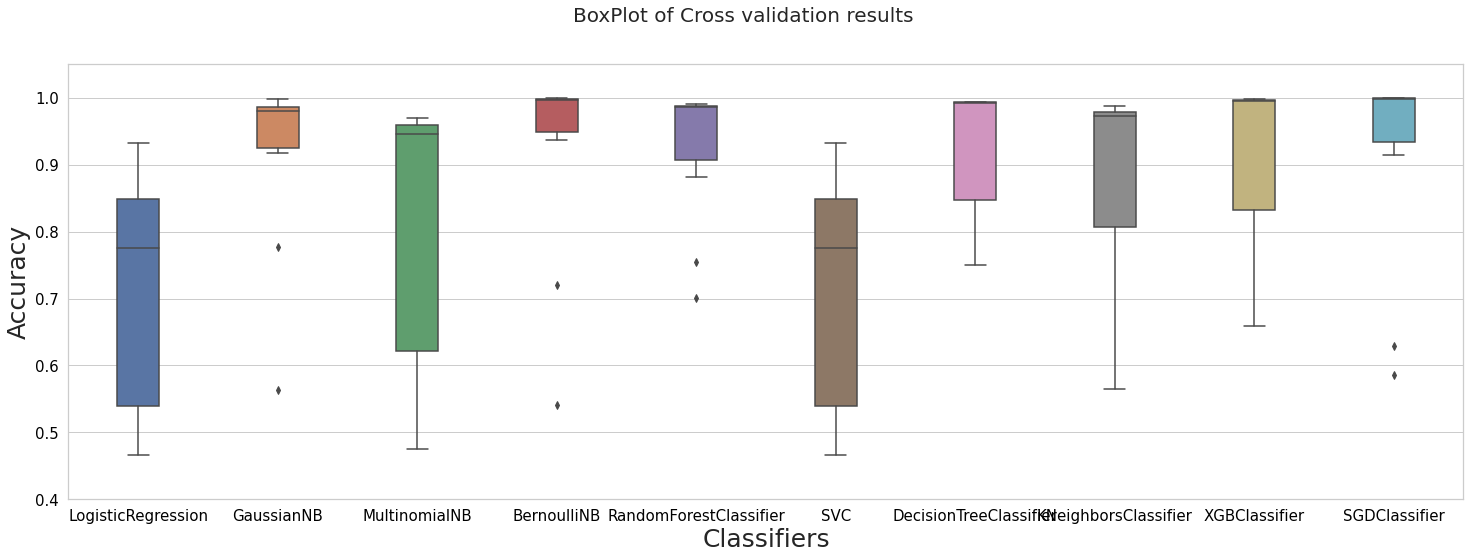

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.set(style="whitegrid")
boxplot=sns.boxplot(data=res,width=0.3)
boxplot.set_ylim([0.4,1.05])
fig.suptitle('BoxPlot of Cross validation results',fontsize=20)
plt.ylabel('Accuracy',fontsize=25)
plt.xlabel('Classifiers',fontsize=25)
plt.tick_params(axis='both', which='major', colors='black', labelsize=15)
plt.show()

#Curve Analysis, Precesion, Recall, F1_score, Confusion Matrix

1) Classifier is : MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

Total time in :  0.00899052619934082

Confusion_matrix is 
 [[2763  481]
 [ 781 2407]]

Precision :  0.8037935323383084
Recall    :  0.8037935323383084
f1_score  :  0.8037935323383084
AUC: 0.803
2) Classifier is : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

Total time in :  0.03195905685424805

Confusion_matrix is 
 [[3220   24]
 [  56 3132]]

Precision :  0.9875621890547264
Recall    :  0.9875621890547264
f1_score  :  0.9875621890547264
AUC: 0.988
3) Classifier is : GaussianNB(priors=None, var_smoothing=0.1)

Total time in :  0.0

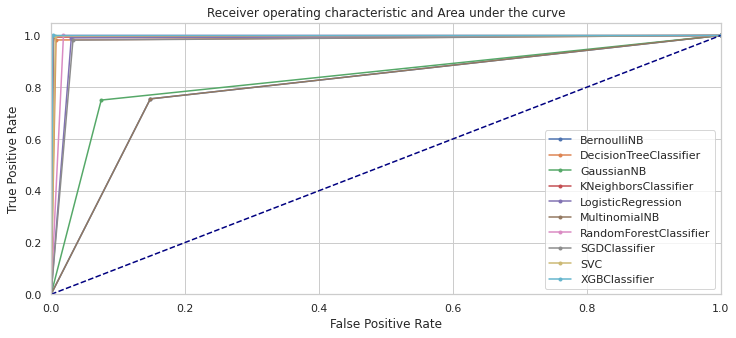

In [ ]:
import time
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
score = []
i=1
plt.subplots(figsize=(12,5))
for n,c in sorted(classifiers.items()):
    start=time.time()
    c.fit(training_x,training_y)
    pred=c.predict(test_x)
    end=time.time()

    print("{}) Classifier is : {}\n".format(i,c))
    print("Total time in : ",end-start)

    score.append((n,[accuracy_score(test_y,pred,normalize=True),metrics.precision_score(test_y,pred,average='micro'),
                    metrics.recall_score(test_y, pred,average='micro'),metrics.f1_score(test_y,pred,average='micro')]))
    
    print("\nConfusion_matrix is \n",confusion_matrix(test_y,pred))
    precision=print("\nPrecision : ",metrics.precision_score(test_y,pred,average='micro'))      
    recall=print("Recall    : ",metrics.recall_score(test_y,pred,average='micro'))
    f1_score=print("f1_score  : ",metrics.f1_score(test_y,pred,average='micro'))
    
    # ROC AND AUC CURVE                                                             
    fpr,tpr,thresholds=roc_curve(test_y,pred)
    # calculate AUC
    auc=roc_auc_score(test_y,pred)
    print('AUC: %.3f' % auc)

    i=i+1
       
    plt.plot(fpr,tpr,marker='.',label=n)
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plot the roc curve for the model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic and Area under the curve')
plt.legend()
plt.show()                

#Accuracy all model in single block

In [ ]:
score_df1=pd.DataFrame.from_dict(dict(score),orient='index',columns=['scores','Precision','Recall','f1_score'])
score_df1['Accuracy (%)']=score_df1['scores']*100
score_df1                   

,scores,Precision,Recall,f1_score,Accuracy (%)
BernoulliNB,0.803794,0.803794,0.803794,0.803794,80.379353
DecisionTreeClassifier,0.987562,0.987562,0.987562,0.987562,98.756219
GaussianNB,0.838464,0.838464,0.838464,0.838464,83.846393
KNeighborsClassifier,0.995025,0.995025,0.995025,0.995025,99.502488
LogisticRegression,0.980100,0.980100,0.980100,0.980100,98.009950
MultinomialNB,0.803794,0.803794,0.803794,0.803794,80.379353
RandomForestClassifier,0.990672,0.990672,0.990672,0.990672,99.067164
SGDClassifier,0.974502,0.974502,0.974502,0.974502,97.450249
SVC,0.995802,0.995802,0.995802,0.995802,99.580224
XGBClassifier,0.998601,0.998601,0.998601,0.998601,99.860075


#Histogram plot for all Models

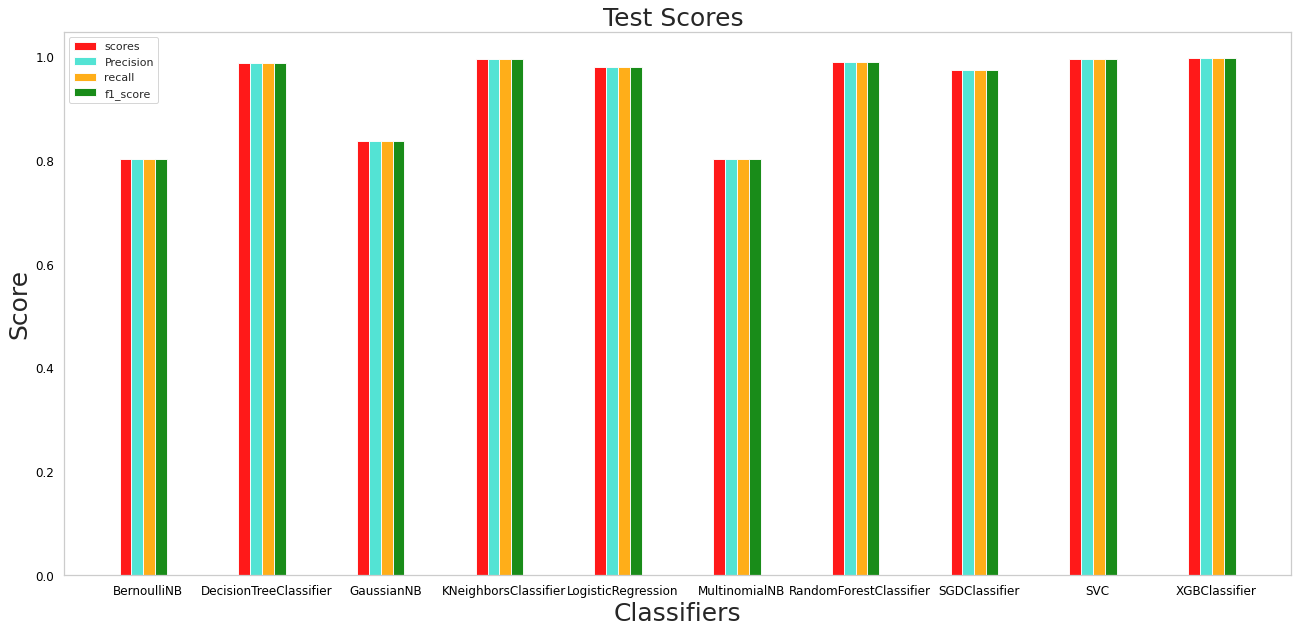

In [ ]:
pos = list(range(len(df1['Classifiers']))) 
width = 0.10 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(22,10)) 
plt.bar(pos,score_df1['scores'],width,alpha=0.9,color='red',label=score_df1['scores'][0]) 
plt.bar([p + width for p in pos],score_df1['Precision'],width,alpha=0.9,color='turquoise',label=score_df1['Precision'][1]) 
plt.bar([p + width*2 for p in pos],score_df1['Recall'],width,alpha=0.9, color='orange',label=score_df1['Recall']) 
plt.bar([p + width*3 for p in pos],score_df1['f1_score'],width,alpha=0.9, color='green',label=score_df1['f1_score']) 
ax.set_ylabel('Score',fontsize=25)
ax.set_xlabel('Classifiers',fontsize=25)
ax.set_title('Test Scores ',fontsize=25)
ax.set_xticks([p + 1.9 * width for p in pos])
ax.set_xticklabels(df1['Classifiers'])
plt.legend(['scores', 'Precision', 'recall','f1_score'], loc='upper left')
plt.grid()
plt.tick_params(axis='both', which='major', colors='black', labelsize=12)
plt.show()